In [1]:
import pandas as pd

In [2]:
import jax
from jax import vmap
import jax.numpy as np
import jax.scipy as sp
import jax.random as random

import numpyro
from numpyro.contrib.module import haiku_module
import numpyro.distributions as dist
from numpyro.distributions import constraints
from numpyro.infer import Trace_ELBO, SVI

In [3]:
import optax
import haiku as hk
from haiku._src.data_structures import FlatMapping

In [4]:
import matplotlib.pyplot as plt

In [5]:
D = pd.read_csv("../data/elections.csv")
D.loc[:, "proportion"] = D.dem / (D.dem + D.rep)
D

,year,dem,rep,region,state,proportion
0,1976,44058,71555,Mountain West,AK,0.381082
1,1980,41842,86112,Mountain West,AK,0.327008
2,1984,62007,138377,Mountain West,AK,0.309441
3,1988,72584,119251,Mountain West,AK,0.378367
4,1992,78294,102000,Mountain West,AK,0.434257
...,...,...,...,...,...,...
545,2000,60481,147947,Mountain West,WY,0.290177
546,2004,70776,167629,Mountain West,WY,0.296873
547,2008,82868,164958,Mountain West,WY,0.334380
548,2012,69286,170962,Mountain West,WY,0.288394


In [6]:
years = pd.to_datetime(D.year)
years = (years - years.min()) / pd.Timedelta(1)

D.loc[:, ("year_numerical")] = years
D.loc[:, ("region_idxs")] = D["region"].apply(
    lambda x: list(D.region.unique()).index(x)
)
D.loc[:, ("state_idxs")] = D["state"].apply(
    lambda x: list(D.state.unique()).index(x)
)
D.loc[:, ("time_idxs")] = D["year_numerical"].apply(
    lambda x: list(D.year_numerical.unique()).index(x)
)
D = D.sort_values(["region", "state", "year_numerical"])
D

,year,dem,rep,region,state,proportion,year_numerical,region_idxs,state_idxs,time_idxs
154,1976,1014714,1183958,Border South,IN,0.461512,0.0,9,14,0
155,1980,844197,1255656,Border South,IN,0.402027,4.0,9,14,1
156,1984,841481,1377230,Border South,IN,0.379266,8.0,9,14,2
157,1988,860643,1297763,Border South,IN,0.398740,12.0,9,14,3
158,1992,848420,989375,Border South,IN,0.461651,16.0,9,14,4
...,...,...,...,...,...,...,...,...,...,...
512,2000,1247652,1108864,West Coast,WA,0.529448,24.0,3,46,6
513,2004,1510201,1304894,West Coast,WA,0.536465,28.0,3,46,7
514,2008,1750848,1229216,West Coast,WA,0.587520,32.0,3,46,8
515,2012,1755396,1290670,West Coast,WA,0.576283,36.0,3,46,9


In [7]:
Y = D[["state", "year_numerical", "proportion"]].pivot_table(
    index="state", values="proportion", columns="year_numerical"
)

In [8]:
Y.head()

year_numerical,0.0,4.0,8.0,12.0,16.0,20.0,24.0,28.0,32.0,36.0,40.0
state,,,,,,,,,,,
AK,0.381082,0.327008,0.309441,0.378367,0.434257,0.395715,0.320631,0.367737,0.389352,0.426847,0.416143
AL,0.566667,0.493237,0.387366,0.402544,0.461789,0.462661,0.424145,0.371022,0.391091,0.387838,0.356259
AR,0.650228,0.496803,0.387724,0.428084,0.599923,0.593528,0.471993,0.450643,0.398283,0.378456,0.357149
AZ,0.413867,0.317879,0.328833,0.392565,0.486981,0.512238,0.467174,0.447250,0.456861,0.453866,0.481100
CA,0.490822,0.405291,0.417755,0.481927,0.585167,0.572163,0.562030,0.550413,0.622784,0.618728,0.661282


In [9]:
X = np.tile(np.array(Y.columns), (Y.shape[0], 1))
X.shape

(50, 11)

In [10]:
X[[0], :]

DeviceArray([[ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36., 40.]], dtype=float32)

In [11]:
Y = np.array(Y.values)
Y.shape

(50, 11)

## Implementing an LSTM

In [12]:
class LSTM(hk.Module):
    def __init__(self, name='lstm'):
        super().__init__(name=name)
        self._w = hk.Linear(4, True, name="w")
        self._u = hk.Linear(4, False, name="u")

    def __call__(self, x):
        outs = [None] * x.shape[-1]
        h, c = np.zeros((x.shape[0], 1)), np.zeros((x.shape[0], 1))
        for i in range(x.shape[-1]):
            o, h, c = self._call(x[:, i, None], h, c)
            outs[i] = o
        return np.hstack(outs)

    def _call(self, x_t, h_t, c_t):                        
        iw, gw, fw, ow = np.split(self._w(x_t), indices_or_sections=4, axis=-1)        
        iu, gu, fu, ou = np.split(self._u(h_t), indices_or_sections=4, axis=-1)        
        i = jax.nn.sigmoid(iw + iu)
        f = jax.nn.sigmoid(fw + fu + 1.0)
        g = np.tanh(gw + gu)
        o = jax.nn.sigmoid(ow + ou)
        c = f * c_t + i * g
        h =  o * np.tanh(c)
        return h, h, c


def _lstm(x):
    module = LSTM()
    return module(x)

In [13]:
key = jax.random.PRNGKey(42)

model = hk.without_apply_rng(hk.transform(_lstm))
params = model.init(key, X[[0], :])
params

FlatMapping({
  'lstm/~/w': FlatMapping({
                'w': DeviceArray([[-0.5389954,  0.8341133, -0.8763848,  1.3341686]], dtype=float32),
                'b': DeviceArray([0., 0., 0., 0.], dtype=float32),
              }),
  'lstm/~/u': FlatMapping({
                'w': DeviceArray([[ 0.6433483 , -0.11852746,  0.88966376, -0.33986157]], dtype=float32),
              }),
})

In [14]:
model.apply(x=X[[0], :], params=params)

DeviceArray([[0.00000000e+00, 1.02649376e-01, 1.43961413e-02,
              1.56547839e-03, 1.79905328e-04, 2.08155125e-05,
              2.41001339e-06, 2.79051449e-07, 3.23111848e-08,
              3.74129749e-09, 4.33203112e-10]], dtype=float32)

In [15]:
def _hk_lstm(x):
    module = hk.LSTM(1)    
    outs, state = hk.dynamic_unroll(module, x, module.initial_state(1))
    return outs

In [16]:
X[ None, [0], :].T.shape

(11, 1, 1)

In [17]:
key = jax.random.PRNGKey(42)

hk_model = hk.without_apply_rng(hk.transform(_hk_lstm))
hk_params = hk_model.init(key, X[ None, [0], :].T)
hk_params

FlatMapping({
  'lstm/linear': FlatMapping({
                   'w': DeviceArray([[-0.51025134,  0.5771896 , -0.09637077, -0.49400634],
                                     [ 0.454539  ,  0.27723938, -1.2919832 , -0.24847537]],            dtype=float32),
                   'b': DeviceArray([0., 0., 0., 0.], dtype=float32),
                 }),
})

In [18]:
hk_model.apply(x=X[ None, [0], :].T, params=hk_params).T

DeviceArray([[[0.0000000e+00, 1.3664528e-02, 1.4810549e-03,
               1.0234739e-04, 5.3378062e-06, 2.1170729e-07,
               6.2559602e-09, 1.3474957e-10, 2.0783360e-12,
               2.2680710e-14, 1.7471644e-16]]], dtype=float32)

In [19]:
w = FlatMapping({
    "w": hk_params['lstm/linear']["w"][[0], :],
    'b': hk_params['lstm/linear']["b"]

})
u = FlatMapping({
    "w": hk_params['lstm/linear']["w"][[1], :],
})

params = FlatMapping({
    'lstm/~/w': w,
    'lstm/~/u': u,
})
params

FlatMapping({
  'lstm/~/w': FlatMapping({
                'w': DeviceArray([[-0.51025134,  0.5771896 , -0.09637077, -0.49400634]], dtype=float32),
                'b': DeviceArray([0., 0., 0., 0.], dtype=float32),
              }),
  'lstm/~/u': FlatMapping({
                'w': DeviceArray([[ 0.454539  ,  0.27723938, -1.2919832 , -0.24847537]], dtype=float32),
              }),
})

In [20]:
model.apply(x=X[[0], :], params=params)

DeviceArray([[0.0000000e+00, 1.3664528e-02, 1.4810549e-03, 1.0234739e-04,
              5.3378062e-06, 2.1170729e-07, 6.2559611e-09, 1.3474961e-10,
              2.0783364e-12, 2.2680715e-14, 1.7471648e-16]],            dtype=float32)

# Implementing an LSTM with a Beta response

In [21]:
Y = D[["state", "year_numerical", "proportion"]].pivot_table(
    index="state", values="proportion", columns="year_numerical"
)

E = np.repeat(np.arange(Y.shape[0]), Y.shape[1]).reshape(Y.shape)
X = np.tile(np.array(Y.columns), (1, Y.shape[0], 1))

In [22]:
xs = []
for i in range(X.T.shape[1]):
    x = X.T[:, [i], :].flatten()
    e = E[i].flatten()
    xe = np.vstack([x, e]).T[:, None]
    xs.append(xe)
X = np.hstack(xs)
X.shape

(11, 50, 2)

In [23]:
X[:, [0], :]

DeviceArray([[[ 0.,  0.]],

             [[ 4.,  0.]],

             [[ 8.,  0.]],

             [[12.,  0.]],

             [[16.,  0.]],

             [[20.,  0.]],

             [[24.,  0.]],

             [[28.,  0.]],

             [[32.,  0.]],

             [[36.,  0.]],

             [[40.,  0.]]], dtype=float32)

In [24]:
X[:, [0, 1], :]

DeviceArray([[[ 0.,  0.],
              [ 0.,  1.]],

             [[ 4.,  0.],
              [ 4.,  1.]],

             [[ 8.,  0.],
              [ 8.,  1.]],

             [[12.,  0.],
              [12.,  1.]],

             [[16.,  0.],
              [16.,  1.]],

             [[20.,  0.],
              [20.,  1.]],

             [[24.,  0.],
              [24.,  1.]],

             [[28.,  0.],
              [28.,  1.]],

             [[32.,  0.],
              [32.,  1.]],

             [[36.,  0.],
              [36.,  1.]],

             [[40.,  0.],
              [40.,  1.]]], dtype=float32)

In [25]:
Y = np.array(Y.values)
Y = Y[None, :, :].T
Y.shape

(11, 50, 1)

In [26]:
Y[:, [0], :]

DeviceArray([[[0.3810817 ]],

             [[0.32700816]],

             [[0.30944088]],

             [[0.37836683]],

             [[0.4342574 ]],

             [[0.39571497]],

             [[0.32063052]],

             [[0.36773717]],

             [[0.38935214]],

             [[0.4268471 ]],

             [[0.41614345]]], dtype=float32)

In [27]:
class BetaLSTM(hk.Module):
    def __init__(self, name='beta_lstm'):
        super().__init__(name=name)        
        self._net = hk.DeepRNN([              
            hk.LSTM(40), jax.nn.relu,
            hk.LSTM(40), jax.nn.relu,
            hk.Linear(1)
        ])
        self._mu = hk.get_parameter('mu', [], init=np.ones)
        self._kappa = hk.get_parameter('kappa', [], init=np.zeros)

    def __call__(self, x):
        p = x.shape[1]
        outs, state = hk.dynamic_unroll(self._net, x, self._net.initial_state(p))
        mu = sp.special.expit(self._mu + outs)
        kappa = np.exp(self._kappa)
        be = dist.Beta(mu * kappa, (1.0 - mu) * kappa)
        return be
        

def _beta_lstm(x):
    module = BetaLSTM()
    return module(x)

In [28]:
beta_model = hk.without_apply_rng(hk.transform(_beta_lstm))

key = jax.random.PRNGKey(42)
params = beta_model.init(key,  X)

In [29]:
beta_model.apply(x=X[:, [0], :], params=params)

In [30]:
beta_model.apply(x=X[:, [0], :], params=params).sample(key=key)

DeviceArray([[[0.9994723 ]],

             [[0.5204014 ]],

             [[0.9997094 ]],

             [[0.8825871 ]],

             [[0.97088987]],

             [[0.04735272]],

             [[0.38127446]],

             [[0.7802068 ]],

             [[0.36030933]],

             [[0.16266209]],

             [[0.11841452]]], dtype=float32)

In [31]:
train_idxs = np.arange(11) != 7

In [32]:
Y[train_idxs, :, :]. shape

(10, 50, 1)

In [36]:
@jax.jit
def nll(params: hk.Params):
    beta = beta_model.apply(x=X, params=params)
    ll = np.sum(beta.log_prob(Y)[train_idxs, :, :])
    return -ll

@jax.jit
def update(params, opt_state):
    val, grads = jax.value_and_grad(nll)(params)  
    updates, new_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_state, val

In [37]:
optimizer = optax.adam(0.001)
opt_state = optimizer.init(params)

In [38]:
nlls = []
for step in range(2000):
    params, opt_state, val = update(params, opt_state)
    nlls.append(float(val))

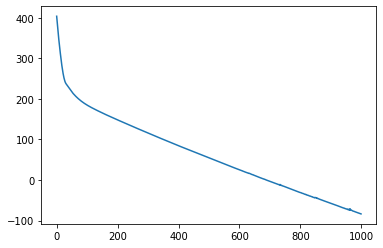

In [39]:
plt.plot(nlls)

In [42]:
beta = beta_model.apply(x=X, params=params)

In [43]:
Y_hat = beta.sample(key=key, sample_shape=(100,))
Y_hat = np.mean(Y_hat, axis=0)

In [44]:
Y[:, [0], :].T

DeviceArray([[[0.3810817 , 0.32700816, 0.30944088, 0.37836683,
               0.4342574 , 0.39571497, 0.32063052, 0.36773717,
               0.38935214, 0.4268471 , 0.41614345]]], dtype=float32)

In [45]:
Y_hat[:, [0], :].T

DeviceArray([[[0.5479486 , 0.4505629 , 0.3772587 , 0.41762558,
               0.49060792, 0.44100362, 0.38730675, 0.39382714,
               0.3966703 , 0.451826  , 0.41996914]]], dtype=float32)

In [46]:
Y[~train_idxs, :, :].shape

(1, 50, 1)

In [48]:
np.mean(np.abs(Y[~train_idxs, :, :] - Y_hat[~train_idxs, :, :]))

DeviceArray(0.07369477, dtype=float32)

# Modelling the latent correlation between time points

In [49]:
class MultivariateLSTM(hk.Module):
    def __init__(self, name='beta_lstm'):
        super().__init__(name=name)        
        self._net = hk.DeepRNN([              
            hk.LSTM(40), jax.nn.relu,
            hk.LSTM(40), jax.nn.relu,
           hk.Linear(1 + 1 + 5)
        ])

    def __call__(self, x):
        p = x.shape[1]
        outs, _ = hk.dynamic_unroll(self._net, x, self._net.initial_state(p))
        mu, d, v = np.split(outs, [1, 2], axis=-1)
        d, v = np.exp(d), v[:, :, None, :]
        return mu, v, d

def _mvn_lstm(x):
    module = MultivariateLSTM()
    return module(x)

beta_model = hk.transform(_mvn_lstm)

In [50]:
def model(y, x, train_idxs):    
    nn = haiku_module("nn", beta_model, x=x)
    mu, v, d =  nn(x)
    f = numpyro.sample("f", dist.LowRankMultivariateNormal(mu, v, d))
    mu = numpyro.deterministic("mu", sp.special.expit(f))
    kappa = numpyro.param("kappa", 1.0, constraint=constraints.positive)
    numpyro.sample(
        "y", 
        dist.Beta(mu[train_idxs, :, :] * kappa, (1.0 - mu[train_idxs, :, :]) * kappa),
        obs=y[train_idxs, :, :]
    )

In [51]:
def guide(y, x, train_idxs):    
    nn = haiku_module("nn", beta_model, x=x)
    mu, v, d =  nn(x)
    numpyro.sample(
        "f", 
        dist.LowRankMultivariateNormal(mu, v, d)
    )

In [52]:
optimizer = numpyro.optim.Adam(step_size=0.001)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
nsteps = 2000
svi_result = svi.run(key, nsteps, y=Y, x=X, train_idxs=train_idxs)

100%|██████████| 1000/1000 [00:26<00:00, 38.39it/s, init loss: 365.7240, avg. loss [951-1000]: -76.0062]


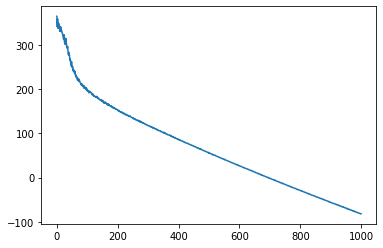

In [53]:
plt.plot(svi_result.losses)

In [55]:
mu, _, _ = beta_model.apply(x=X, params=svi_result.params['nn$params'], rng=key)
mu = sp.special.expit(mu)
kappa = svi_result.params['kappa']

In [61]:
Y_hat = dist.Beta(mu * kappa, (1.0 - mu) * kappa).sample(key=key, sample_shape=(100,))
Y_hat = np.mean(Y_hat, axis=0)

In [62]:
Y_hat.shape

(11, 50, 1)

In [63]:
Y[:, [0], :].T

DeviceArray([[[0.3810817 , 0.32700816, 0.30944088, 0.37836683,
               0.4342574 , 0.39571497, 0.32063052, 0.36773717,
               0.38935214, 0.4268471 , 0.41614345]]], dtype=float32)

In [64]:
Y_hat[:, [0], :].T

DeviceArray([[[0.4742524 , 0.4340856 , 0.3733245 , 0.42280295,
               0.49100956, 0.43636292, 0.4332401 , 0.40837148,
               0.38670686, 0.43128073, 0.4029676 ]]], dtype=float32)

In [65]:
np.mean(np.abs(Y[~train_idxs, :, :] - Y_hat[~train_idxs, :, :]))

DeviceArray(0.07332736, dtype=float32)